In [4]:
import pandas as pd
import numpy as np
import missingno as msno
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import root_mean_squared_error
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.preprocessing import LabelEncoder
from matplotlib import pyplot as plt
from datetime import datetime
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [6]:
df_train=pd.read_csv("train.csv", index_col="id")
df_test=pd.read_csv("test.csv", index_col="id")
df_train.columns = df_train.columns.str.lower().str.replace(" ", "_")
df_test.columns = df_test.columns.str.lower().str.replace(" ", "_")

In [8]:
df_train.sample(10)

,brand,material,size,compartments,laptop_compartment,waterproof,style,color,weight_capacity_(kg),price
id,,,,,,,,,,
219814,Jansport,Nylon,Small,3.0,NaN,No,Tote,Gray,10.593878,103.99386
295244,Adidas,Polyester,Small,3.0,No,No,Backpack,Green,22.182760,139.24447
76194,Adidas,Canvas,Medium,10.0,Yes,No,Messenger,Black,9.955321,30.80751
279604,Nike,Nylon,Medium,3.0,Yes,No,Messenger,Gray,7.154592,92.48339
221962,Adidas,Polyester,Large,8.0,No,No,Tote,Green,19.312471,108.78533
24477,Jansport,NaN,Large,9.0,No,No,Messenger,Red,13.947112,95.90259
210872,Jansport,Canvas,Small,9.0,No,No,Tote,Pink,22.959336,150.00000
46678,Puma,Nylon,Medium,2.0,No,Yes,Messenger,Blue,17.066004,62.96838
284737,Nike,Leather,Large,10.0,Yes,Yes,Tote,Blue,12.986770,134.02219


In [10]:
df_test.sample(5)

,brand,material,size,compartments,laptop_compartment,waterproof,style,color,weight_capacity_(kg)
id,,,,,,,,,
407219,Puma,Polyester,Small,8.0,No,No,Messenger,Green,11.270823
358628,Under Armour,Polyester,Small,5.0,No,Yes,Backpack,Pink,20.941493
487249,Puma,Nylon,Medium,9.0,No,Yes,Backpack,Red,12.594315
353927,Adidas,Canvas,Large,4.0,Yes,No,Backpack,Red,11.914193
309548,Adidas,Leather,Small,2.0,Yes,No,Backpack,Black,16.897658


In [12]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 300000 entries, 0 to 299999
Data columns (total 10 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   brand                 290295 non-null  object 
 1   material              291653 non-null  object 
 2   size                  293405 non-null  object 
 3   compartments          300000 non-null  float64
 4   laptop_compartment    292556 non-null  object 
 5   waterproof            292950 non-null  object 
 6   style                 292030 non-null  object 
 7   color                 290050 non-null  object 
 8   weight_capacity_(kg)  299862 non-null  float64
 9   price                 300000 non-null  float64
dtypes: float64(3), object(7)
memory usage: 25.2+ MB


In [14]:
df_train.isnull().sum()*100/len(df_train)

brand                   3.235000
material                2.782333
size                    2.198333
compartments            0.000000
laptop_compartment      2.481333
waterproof              2.350000
style                   2.656667
color                   3.316667
weight_capacity_(kg)    0.046000
price                   0.000000
dtype: float64

In [18]:
df_test.isnull().sum()*100/len(df_train)

brand                   2.075667
material                1.871000
size                    1.460333
compartments            0.000000
laptop_compartment      1.654000
waterproof              1.603667
style                   1.717667
color                   2.261667
weight_capacity_(kg)    0.025667
dtype: float64

<Axes: >

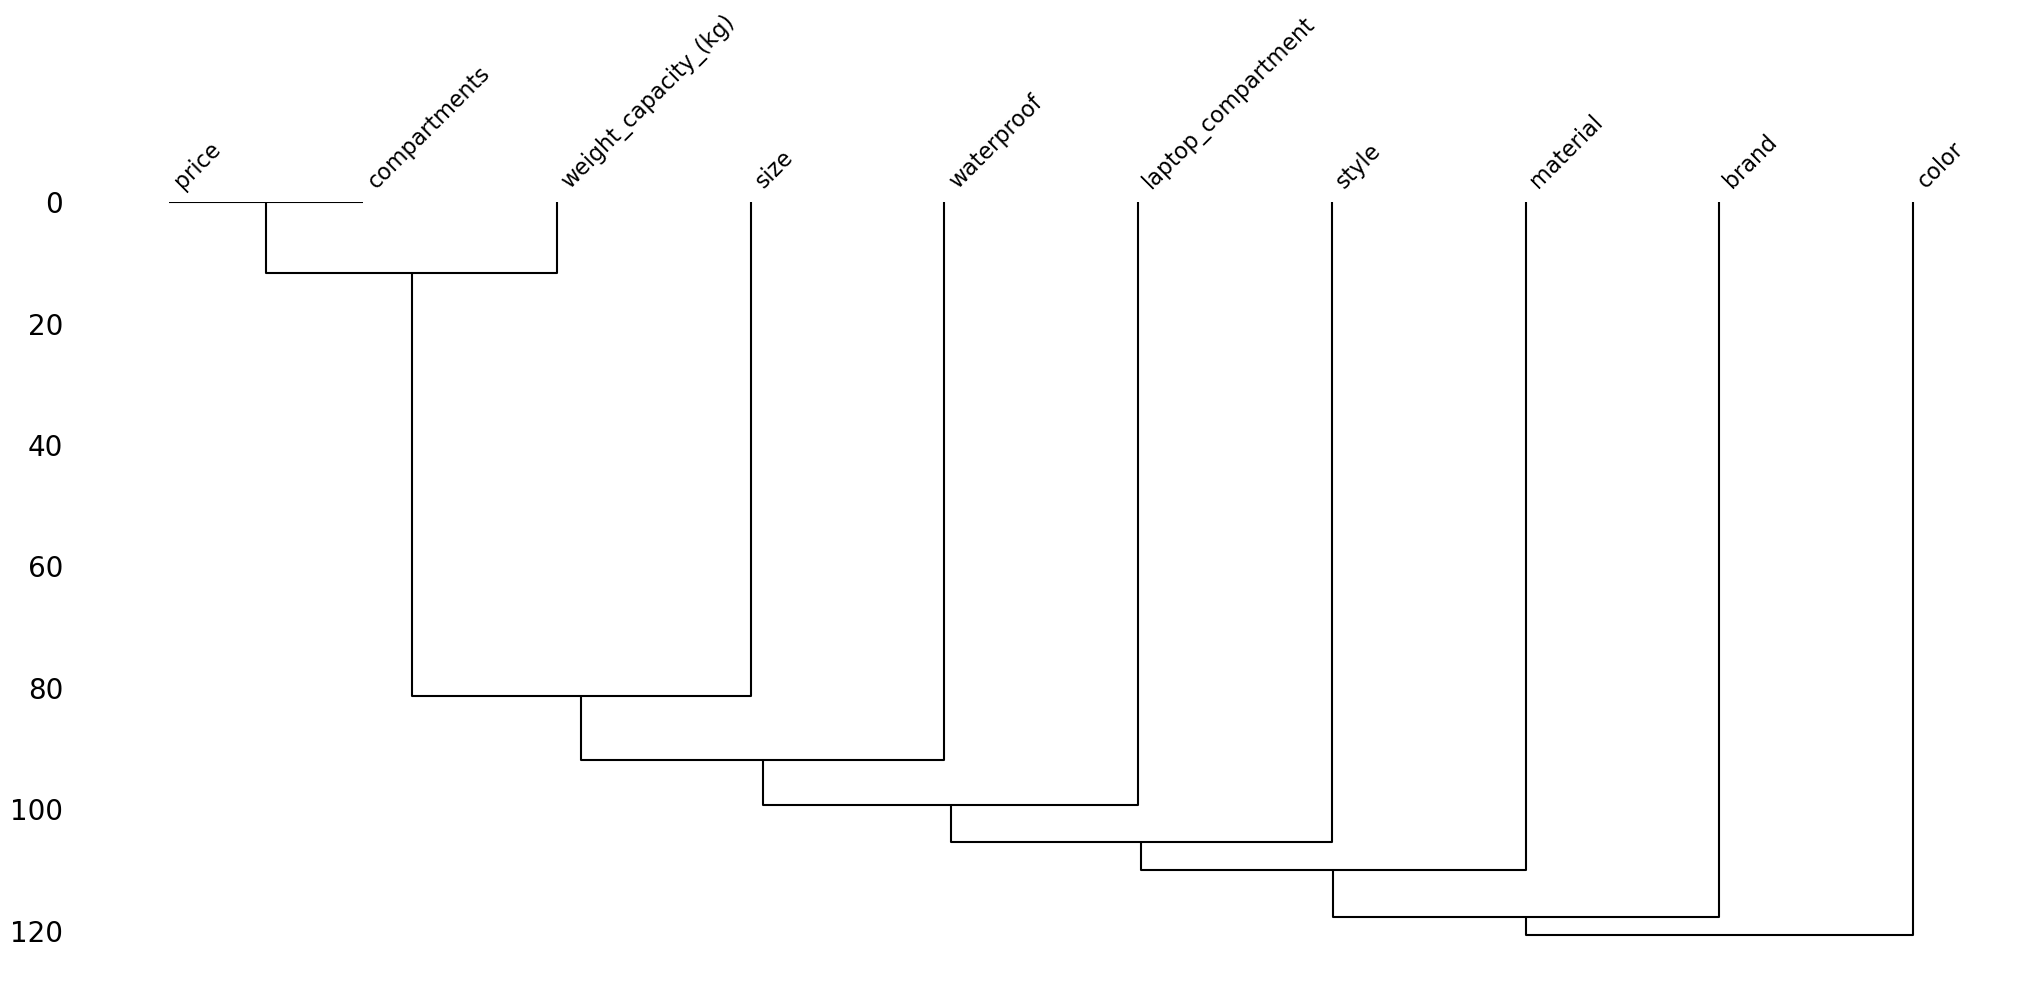

In [20]:
msno.dendrogram(df_train)

In [22]:
df_train["interpol_wt_cap_kg"]=df_train["weight_capacity_(kg)"].interpolate(method="linear")
df_test["interpol_wt_cap_kg"]=df_test["weight_capacity_(kg)"].interpolate(method="linear")

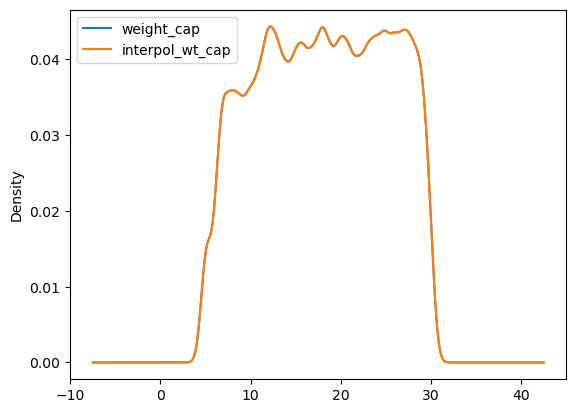

In [24]:
df_train["weight_capacity_(kg)"].plot(kind="kde", label = "weight_cap")
df_train["interpol_wt_cap_kg"].plot(kind="kde", label ="interpol_wt_cap")
plt.legend()
plt.show()

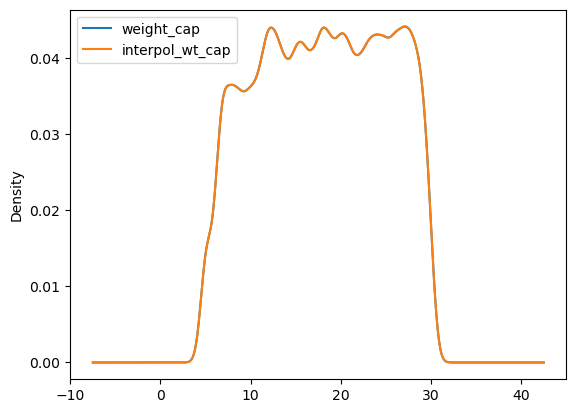

In [26]:
df_test["weight_capacity_(kg)"].plot(kind="kde", label = "weight_cap")
df_test["interpol_wt_cap_kg"].plot(kind="kde", label ="interpol_wt_cap")
plt.legend()
plt.show()

In [28]:
df_train.drop(columns="weight_capacity_(kg)", inplace=True)
df_test.drop(columns="weight_capacity_(kg)", inplace=True)

In [30]:
cat_cols = df_train.select_dtypes(include="object").columns

In [32]:
cat_cols

Index(['brand', 'material', 'size', 'laptop_compartment', 'waterproof',
       'style', 'color'],
      dtype='object')

In [34]:
# Dictionary to store encoders
label_encoders = {}

# Apply LabelEncoder to each categorical column
for col in cat_cols:
    le = LabelEncoder()
    df_train[col] = df_train[col].astype(str)  # Convert to string to avoid issues
    df_train[col] = le.fit_transform(df_train[col])  # Fit & transform column
    df_test[col] = df_test[col].astype(str)  # Convert to string to avoid issues
    df_test[col] = le.fit_transform(df_test[col])  # Fit & transform column
    label_encoders[col] = le  # Store encoder for later use

# Check encoded values
for col in cat_cols:
    print(f"Classes for {col}: {list(label_encoders[col].classes_)}")

Classes for brand: ['Adidas', 'Jansport', 'Nike', 'Puma', 'Under Armour', 'nan']
Classes for material: ['Canvas', 'Leather', 'Nylon', 'Polyester', 'nan']
Classes for size: ['Large', 'Medium', 'Small', 'nan']
Classes for laptop_compartment: ['No', 'Yes', 'nan']
Classes for waterproof: ['No', 'Yes', 'nan']
Classes for style: ['Backpack', 'Messenger', 'Tote', 'nan']
Classes for color: ['Black', 'Blue', 'Gray', 'Green', 'Pink', 'Red', 'nan']


In [42]:
for col in cat_cols:
   value_counts_train = df_train[col].value_counts()
   value_counts_test = df_test[col].value_counts()
   print([value_counts_test,value_counts_train])

[brand
0    40173
4    40139
2    38273
3    37857
1    37331
5     6227
Name: count, dtype: int64, brand
0    60077
4    59992
2    57336
3    56814
1    56076
5     9705
Name: count, dtype: int64]
[material
3    53027
1    48989
2    47493
0    44878
4     5613
Name: count, dtype: int64, material
3    79630
1    73416
2    70603
0    68004
4     8347
Name: count, dtype: int64]
[size
1    67775
0    65684
2    62160
3     4381
Name: count, dtype: int64, size
1    101906
0     98643
2     92856
3      6595
Name: count, dtype: int64]
[laptop_compartment
1    98659
0    96379
2     4962
Name: count, dtype: int64, laptop_compartment
1    148342
0    144214
2      7444
Name: count, dtype: int64]
[waterproof
1    98594
0    96595
2     4811
Name: count, dtype: int64, waterproof
1    148077
0    144873
2      7050
Name: count, dtype: int64]
[style
1    66387
2    65089
0    63371
3     5153
Name: count, dtype: int64, style
1    100031
2     97438
0     94561
3      7970
Name: count, dtype: i

In [50]:
df_train["color"] = df_train["color"].map(lambda x: np.nan if x==6 else x)
df_train["style"] = df_train["style"].map(lambda x: np.nan if x==3 else x)
df_train["waterproof"] = df_train["waterproof"].map(lambda x: np.nan if x==2 else x)
df_train["laptop_compartment"] = df_train["laptop_compartment"].map(lambda x: np.nan if x==2 else x)
df_train["size"] = df_train["size"].map(lambda x: np.nan if x==3 else x)
df_train["material"] = df_train["material"].map(lambda x: np.nan if x==4 else x)
df_train["brand"] = df_train["brand"].map(lambda x: np.nan if x==5 else x)
df_test["color"] = df_test["color"].map(lambda x: np.nan if x==6 else x)
df_test["style"] = df_test["style"].map(lambda x: np.nan if x==3 else x)
df_test["waterproof"] = df_test["waterproof"].map(lambda x: np.nan if x==2 else x)
df_test["laptop_compartment"] = df_test["laptop_compartment"].map(lambda x: np.nan if x==2 else x)
df_test["size"] = df_test["size"].map(lambda x: np.nan if x==3 else x)
df_test["material"] = df_test["material"].map(lambda x: np.nan if x==4 else x)
df_test["brand"] = df_test["brand"].map(lambda x: np.nan if x==5 else x)


In [46]:
df_train

,brand,material,size,compartments,laptop_compartment,waterproof,style,color,price,interpol_wt_cap_kg
id,,,,,,,,,,
0,1.0,1.0,1.0,7.0,1.0,0.0,2.0,0.0,112.15875,11.611723
1,1.0,0.0,2.0,10.0,1.0,1.0,1.0,3.0,68.88056,27.078537
2,4.0,1.0,2.0,2.0,1.0,0.0,1.0,5.0,39.17320,16.643760
3,2.0,2.0,2.0,8.0,1.0,0.0,1.0,3.0,80.60793,12.937220
4,0.0,0.0,1.0,1.0,1.0,1.0,1.0,3.0,86.02312,17.749338
...,...,...,...,...,...,...,...,...,...,...
299995,0.0,1.0,2.0,9.0,0.0,0.0,2.0,1.0,129.99749,12.730812
299996,1.0,1.0,0.0,6.0,0.0,1.0,2.0,1.0,19.85819,26.633182
299997,3.0,0.0,0.0,9.0,1.0,1.0,0.0,4.0,111.41364,11.898250


In [52]:
df_test

,brand,material,size,compartments,laptop_compartment,waterproof,style,color,interpol_wt_cap_kg
id,,,,,,,,,
300000,3.0,1.0,2.0,2.0,0.0,0.0,2.0,3.0,20.671147
300001,2.0,0.0,1.0,7.0,0.0,1.0,0.0,3.0,13.564105
300002,0.0,0.0,0.0,9.0,0.0,1.0,1.0,1.0,11.809799
300003,0.0,2.0,0.0,1.0,1.0,0.0,1.0,3.0,18.477036
300004,NaN,2.0,0.0,2.0,1.0,1.0,2.0,0.0,9.907953
...,...,...,...,...,...,...,...,...,...
499995,0.0,0.0,0.0,2.0,1.0,0.0,1.0,5.0,7.383498
499996,2.0,3.0,2.0,9.0,0.0,1.0,1.0,4.0,6.058394
499997,1.0,2.0,2.0,9.0,0.0,1.0,2.0,3.0,26.890163


In [54]:
df_train.isnull().sum()

brand                 9705
material              8347
size                  6595
compartments             0
laptop_compartment    7444
waterproof            7050
style                 7970
color                 9950
price                    0
interpol_wt_cap_kg       0
dtype: int64

In [56]:
df_test.isnull().sum()

brand                 6227
material              5613
size                  4381
compartments             0
laptop_compartment    4962
waterproof            4811
style                 5153
color                 6785
interpol_wt_cap_kg       0
dtype: int64

In [58]:
# mice imputation
imputer = IterativeImputer(random_state=42)

In [60]:
df_train[cat_cols] = imputer.fit_transform(df_train[cat_cols]).astype(int)

In [62]:
df_test[cat_cols] = imputer.fit_transform(df_test[cat_cols]).astype(int)

In [66]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 200000 entries, 300000 to 499999
Data columns (total 9 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   brand               200000 non-null  int32  
 1   material            200000 non-null  int32  
 2   size                200000 non-null  int32  
 3   compartments        200000 non-null  float64
 4   laptop_compartment  200000 non-null  int32  
 5   waterproof          200000 non-null  int32  
 6   style               200000 non-null  int32  
 7   color               200000 non-null  int32  
 8   interpol_wt_cap_kg  200000 non-null  float64
dtypes: float64(2), int32(7)
memory usage: 9.9 MB


In [68]:
 # Inverse transform each categorical column
for col in cat_cols:
    df_train[col] = label_encoders[col].inverse_transform(df_train[col])
    df_test[col] = label_encoders[col].inverse_transform(df_test[col])

In [70]:
df_train[cat_cols]=df_train[cat_cols].astype("category")
df_test[cat_cols]=df_test[cat_cols].astype("category")

In [72]:
df_train

,brand,material,size,compartments,laptop_compartment,waterproof,style,color,price,interpol_wt_cap_kg
id,,,,,,,,,,
0,Jansport,Leather,Medium,7.0,Yes,No,Tote,Black,112.15875,11.611723
1,Jansport,Canvas,Small,10.0,Yes,Yes,Messenger,Green,68.88056,27.078537
2,Under Armour,Leather,Small,2.0,Yes,No,Messenger,Red,39.17320,16.643760
3,Nike,Nylon,Small,8.0,Yes,No,Messenger,Green,80.60793,12.937220
4,Adidas,Canvas,Medium,1.0,Yes,Yes,Messenger,Green,86.02312,17.749338
...,...,...,...,...,...,...,...,...,...,...
299995,Adidas,Leather,Small,9.0,No,No,Tote,Blue,129.99749,12.730812
299996,Jansport,Leather,Large,6.0,No,Yes,Tote,Blue,19.85819,26.633182
299997,Puma,Canvas,Large,9.0,Yes,Yes,Backpack,Pink,111.41364,11.898250


In [74]:
df_test

,brand,material,size,compartments,laptop_compartment,waterproof,style,color,interpol_wt_cap_kg
id,,,,,,,,,
300000,Puma,Leather,Small,2.0,No,No,Tote,Green,20.671147
300001,Nike,Canvas,Medium,7.0,No,Yes,Backpack,Green,13.564105
300002,Adidas,Canvas,Large,9.0,No,Yes,Messenger,Blue,11.809799
300003,Adidas,Nylon,Large,1.0,Yes,No,Messenger,Green,18.477036
300004,Nike,Nylon,Large,2.0,Yes,Yes,Tote,Black,9.907953
...,...,...,...,...,...,...,...,...,...
499995,Adidas,Canvas,Large,2.0,Yes,No,Messenger,Red,7.383498
499996,Nike,Polyester,Small,9.0,No,Yes,Messenger,Pink,6.058394
499997,Jansport,Nylon,Small,9.0,No,Yes,Tote,Green,26.890163


In [76]:
X= df_train.drop("price", axis=1)
y= df_train["price"]

In [78]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 300000 entries, 0 to 299999
Data columns (total 9 columns):
 #   Column              Non-Null Count   Dtype   
---  ------              --------------   -----   
 0   brand               300000 non-null  category
 1   material            300000 non-null  category
 2   size                300000 non-null  category
 3   compartments        300000 non-null  float64 
 4   laptop_compartment  300000 non-null  category
 5   waterproof          300000 non-null  category
 6   style               300000 non-null  category
 7   color               300000 non-null  category
 8   interpol_wt_cap_kg  300000 non-null  float64 
dtypes: category(7), float64(2)
memory usage: 8.9 MB


In [80]:
lgm = LGBMRegressor(categorical_feature=list(cat_cols),on_estimators=100, random_state=42)
scores= cross_val_score(lgm,X,y,cv=5,scoring="neg_root_mean_squared_error")
print(scores.mean())

[LightGBM] [Warning] Unknown parameter: on_estimators
[LightGBM] [Warning] Unknown parameter: on_estimators
[LightGBM] [Warning] categorical_feature is set=brand,material,size,laptop_compartment,waterproof,style,color, categorical_column=0,1,2,4,5,6,7 will be ignored. Current value: categorical_feature=brand,material,size,laptop_compartment,waterproof,style,color
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007633 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 298
[LightGBM] [Info] Number of data points in the train set: 240000, number of used features: 9
[LightGBM] [Info] Start training from score 81.474972
[LightGBM] [Warning] Unknown parameter: on_estimators
[LightGBM] [Warning] Unknown parameter: on_estimators
[LightGBM] [Warning] Unknown parameter: on_estimators
[LightGBM] [Warning] categorical_feature is set=brand,material,siz

In [82]:
X_train,X_val,y_train,y_val= train_test_split(X,y,test_size=0.2,random_state=42)

In [84]:
lgm1=lgm.fit(X_train,y_train)
feature_imp = pd.DataFrame({
    "feature":X_train.columns,
    "LGBM_importance": lgm1.feature_importances_
}).sort_values(by="LGBM_importance", ascending = False)


[LightGBM] [Warning] Unknown parameter: on_estimators
[LightGBM] [Warning] Unknown parameter: on_estimators
[LightGBM] [Warning] categorical_feature is set=brand,material,size,laptop_compartment,waterproof,style,color, categorical_column=0,1,2,4,5,6,7 will be ignored. Current value: categorical_feature=brand,material,size,laptop_compartment,waterproof,style,color
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.138818 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 298
[LightGBM] [Info] Number of data points in the train set: 240000, number of used features: 9
[LightGBM] [Info] Start training from score 81.448481


In [86]:
feature_imp

,feature,LGBM_importance
8,interpol_wt_cap_kg,1029
3,compartments,483
7,color,282
6,style,274
2,size,251
0,brand,244
1,material,166
5,waterproof,137
4,laptop_compartment,134


In [88]:
lgm.fit(X_train,y_train)

[LightGBM] [Warning] Unknown parameter: on_estimators
[LightGBM] [Warning] Unknown parameter: on_estimators
[LightGBM] [Warning] categorical_feature is set=brand,material,size,laptop_compartment,waterproof,style,color, categorical_column=0,1,2,4,5,6,7 will be ignored. Current value: categorical_feature=brand,material,size,laptop_compartment,waterproof,style,color
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004172 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 298
[LightGBM] [Info] Number of data points in the train set: 240000, number of used features: 9
[LightGBM] [Info] Start training from score 81.448481


LGBMRegressor(categorical_feature=['brand', 'material', 'size',
                                   'laptop_compartment', 'waterproof', 'style',
                                   'color'],
              on_estimators=100, random_state=42)

In [90]:
y_pred = lgm.predict(X_val)

[LightGBM] [Warning] Unknown parameter: on_estimators


In [92]:
root_mean_squared_error(y_val,y_pred)

38.928917252940884

In [95]:
y_test=lgm.predict(df_test)

[LightGBM] [Warning] Unknown parameter: on_estimators


In [101]:
df_test["price"] =y_test.round(3)

In [105]:
df_test

,brand,material,size,compartments,laptop_compartment,waterproof,style,color,interpol_wt_cap_kg,price
id,,,,,,,,,,
300000,Puma,Leather,Small,2.0,No,No,Tote,Green,20.671147,82.250
300001,Nike,Canvas,Medium,7.0,No,Yes,Backpack,Green,13.564105,82.428
300002,Adidas,Canvas,Large,9.0,No,Yes,Messenger,Blue,11.809799,82.364
300003,Adidas,Nylon,Large,1.0,Yes,No,Messenger,Green,18.477036,80.702
300004,Nike,Nylon,Large,2.0,Yes,Yes,Tote,Black,9.907953,78.589
...,...,...,...,...,...,...,...,...,...,...
499995,Adidas,Canvas,Large,2.0,Yes,No,Messenger,Red,7.383498,78.554
499996,Nike,Polyester,Small,9.0,No,Yes,Messenger,Pink,6.058394,81.722
499997,Jansport,Nylon,Small,9.0,No,Yes,Tote,Green,26.890163,84.153


In [110]:
df_test.drop(columns=['brand', 'material', 'size', 'compartments', 'laptop_compartment',
       'waterproof', 'style', 'color', 'interpol_wt_cap_kg'], inplace=True)

In [112]:
df_test

,price
id,
300000,82.250
300001,82.428
300002,82.364
300003,80.702
300004,78.589
...,...
499995,78.554
499996,81.722
499997,84.153


In [117]:
df_test.to_csv("backpack_prediction_challenge.csv", index=True)